In [1]:
import pandas as pd
from pathlib import Path
import parse
from collections import deque

base_path = Path("./output")
timing_fmt_matcher = parse.compile("lat{latency:d}_var{variance:d}_corr{corr:d}")
exp_fmt_matcher = parse.compile("{model_name}_{rep:d}_of_{total_reps:d}")

dfs = deque()

for exp_dir in base_path.iterdir():
    res = timing_fmt_matcher.parse(exp_dir.name)
    one_way_latency = res["latency"]
    one_way_variance = res["variance"]
    one_way_corr = res["corr"]
    lat_var = f"{one_way_latency:04d}ms / {one_way_variance:03d}ms"
    for rep_dir in exp_dir.iterdir():
        res = exp_fmt_matcher.parse(rep_dir.name)
        model = res["model_name"]
        rep = res["rep"]
        
        steps_file = rep_dir / "client.steps.csv"
        steps_csv = pd.read_csv(steps_file)
        
        steps_csv["one_way_latency"] = one_way_latency
        steps_csv["one_way_variance"] = one_way_variance
        steps_csv["model"] = model
        steps_csv["rep"] = rep
        steps_csv["one_way_corr"] = one_way_corr
        steps_csv["lat_var"] = lat_var
        
        dfs.append(steps_csv)
    
data = pd.concat(dfs, ignore_index=True)
data["task_duration"] = data.groupby(["one_way_latency", "one_way_variance", "one_way_corr", "model", "rep"])["step_duration"].cumsum()
lat_var = pd.CategoricalDtype(sorted(data["lat_var"].unique()), ordered=True)
data["lat_var"] = data["lat_var"].astype(lat_var)

data["model"] = data["model"].replace({
    "first-order": "Ref. Stochastic",
    "first-order-median": "Ref. Median",
    "curve-low-neuro": "3rd Order Poly. (low neuroticism)",  # multi-curve always fits 3rd
    "curve-high-neuro": "3rd Order Poly. (high neuroticism)",
    "legacy": "Legacy EdgeDroid 1.0"
}).astype("category")

data

,step_number,step_start,step_start_monotonic,step_end,step_end_monotonic,first_frame_monotonic,last_frame_monotonic,last_frame_rtt,execution_time,step_duration,time_to_feedback,wait_time,frame_count,one_way_latency,one_way_variance,model,rep,one_way_corr,lat_var,task_duration
0,0,1.715994e+09,263738.948506,1.715994e+09,263740.260528,263738.949561,263738.949561,1.310967,0.000000,1.312022,1.312022,0.001056,1,100,20,Ref. Median,6,0,0100ms / 020ms,1.312022
1,1,1.715994e+09,263740.260528,1.715994e+09,263746.158942,263740.263091,263745.539104,0.619838,5.230947,5.898414,0.667467,0.047629,19,100,20,Ref. Median,6,0,0100ms / 020ms,7.210436
2,2,1.715994e+09,263746.158942,1.715994e+09,263752.311376,263746.161966,263751.633897,0.677479,5.230947,6.152435,0.921487,0.244008,13,100,20,Ref. Median,6,0,0100ms / 020ms,13.362871
3,3,1.715994e+09,263752.311376,1.715994e+09,263758.305689,263752.313255,263757.713409,0.592280,5.230947,5.994312,0.763365,0.171086,11,100,20,Ref. Median,6,0,0100ms / 020ms,19.357183
4,4,1.715994e+09,263758.305689,1.715994e+09,263764.400132,263758.307348,263763.814831,0.585301,5.230947,6.094443,0.863496,0.278195,13,100,20,Ref. Median,6,0,0100ms / 020ms,25.451626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,46,1.715926e+09,196382.817530,1.715926e+09,196387.413530,196382.818729,196386.899198,0.514332,4.049000,4.595999,0.546999,0.032667,15,50,10,Legacy EdgeDroid 1.0,6,0,0050ms / 010ms,215.104562
45896,47,1.715926e+09,196387.413530,1.715926e+09,196392.237547,196387.414592,196391.715969,0.521578,4.049000,4.824017,0.775017,0.253439,16,50,10,Legacy EdgeDroid 1.0,6,0,0050ms / 010ms,219.928579
45897,48,1.715926e+09,196392.237547,1.715926e+09,196396.843498,196392.238668,196396.344372,0.499126,4.049000,4.605951,0.556951,0.057825,16,50,10,Legacy EdgeDroid 1.0,6,0,0050ms / 010ms,224.534530
45898,49,1.715926e+09,196396.843498,1.715926e+09,196401.557479,196396.844844,196401.009401,0.548077,4.049000,4.713981,0.664981,0.116904,14,50,10,Legacy EdgeDroid 1.0,6,0,0050ms / 010ms,229.248511


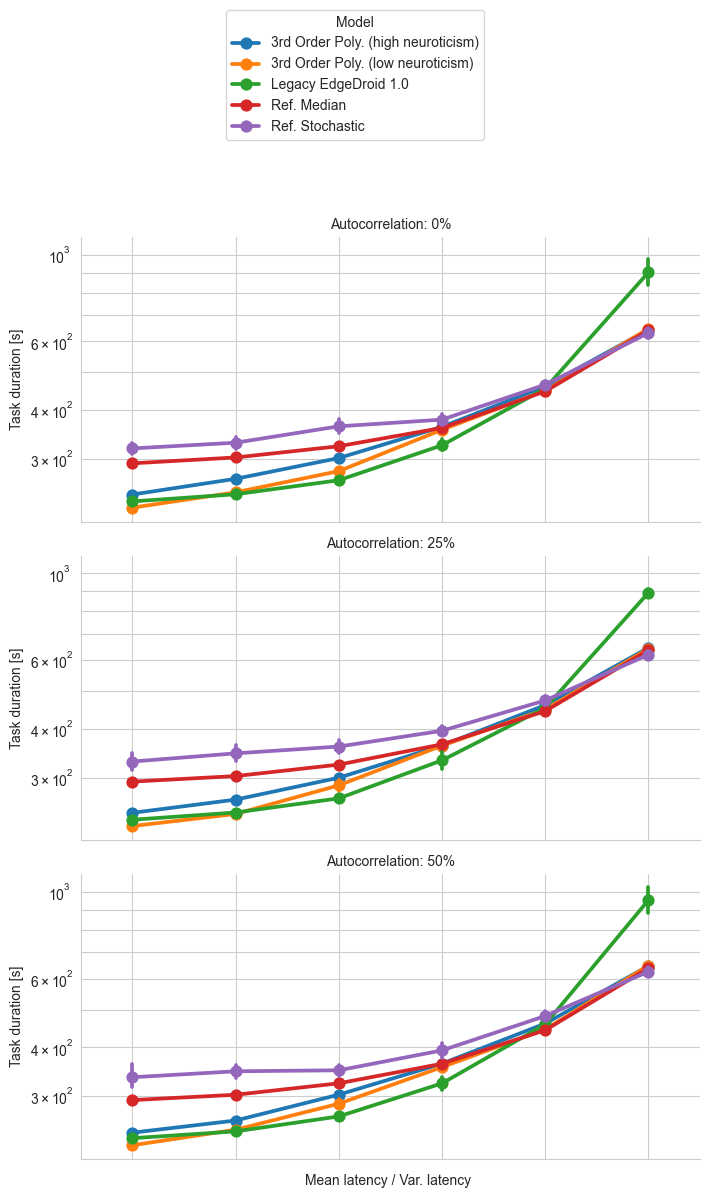

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

DOUBLE_COL_FIGW = 7.16

last_step_data = data[data["step_number"] == data["step_number"].max()]
# last_step_data = last_step_data[np.isin(last_step_data["one_way_corr"], (0, 50))]


fg = sns.catplot(
    kind="point", 
    data=last_step_data, 
    x="lat_var", 
    y="task_duration", 
    row="one_way_corr", 
    hue="model",
    legend=True,
    legend_out=False,
    col_wrap=None,
    aspect=1,
)
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

fg.set_axis_labels("Mean latency / Var. latency ", "Task duration [s]")
fg.set_titles(col_template="Autocorrelation: {col_name}%", row_template="Autocorrelation: {row_name}%")
fg.legend.set_title("Model")
sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.2), ncols=1)

fg.set(yscale="log")
# tpl.save("./frame_corr_task_dur.tex")
fg.figure.set_size_inches((2*3.6, 2*5))
fg.tight_layout()
plt.show()

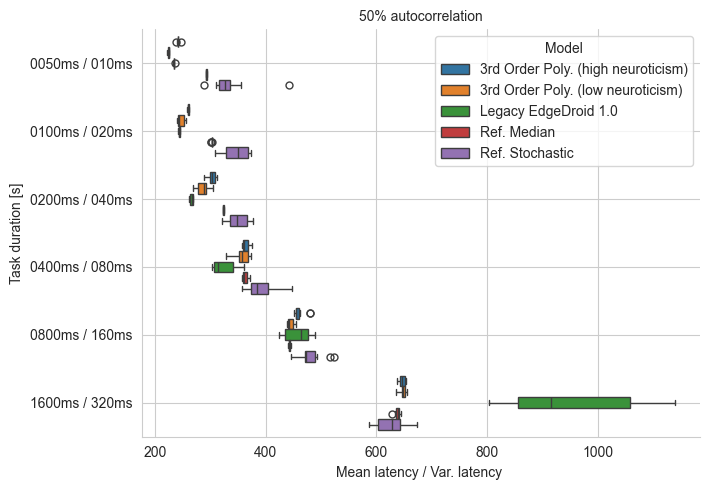

In [3]:
fg = sns.catplot(
    kind="box",
    data=last_step_data[last_step_data.one_way_corr == 50],
    y="lat_var",
    x="task_duration",
    row="one_way_corr",
    hue="model",
    legend=True,
    legend_out=False,
    col_wrap=None,
    aspect=1,
)
for ax in fg.axes.flat:
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.yaxis.grid(True, which="minor")
    ax.yaxis.grid(True, which="major")
    ax.xaxis.grid(True)

fg.set_axis_labels("Mean latency / Var. latency ", "Task duration [s]")
fg.set_titles(col_template="Autocorrelation: {col_name}%", row_template="{row_name}% autocorrelation")
fg.legend.set_title("Model")
# sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.2), ncols=1)

fg.legend.set_title("Model")
# sns.move_legend(fg, "upper center", bbox_to_anchor=(.5, 1.55), ncols=1)
fg.figure.set_size_inches((2*3.6, 2*2.5))
fg.tight_layout()
plt.show()

In [4]:
mean_task_duration = last_step_data.groupby(["lat_var", "one_way_corr", "model"], observed=True)["task_duration"].mean().to_frame()
a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[0, 1]).transform("first")
diff_wrt_hn = (mean_task_duration["task_duration"] - a) / a
diff_wrt_hn

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_33084/75902871.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (high neuroticism)").groupby(level=[0, 1]).transform("first")


lat_var         one_way_corr  model                             
0050ms / 010ms  0             3rd Order Poly. (high neuroticism)    0.000000
                              3rd Order Poly. (low neuroticism)    -0.074327
                              Legacy EdgeDroid 1.0                 -0.039805
                              Ref. Median                           0.201736
                              Ref. Stochastic                       0.312189
                                                                      ...   
1600ms / 320ms  50            3rd Order Poly. (high neuroticism)    0.000000
                              3rd Order Poly. (low neuroticism)     0.002228
                              Legacy EdgeDroid 1.0                  0.473680
                              Ref. Median                          -0.012850
                              Ref. Stochastic                      -0.032948
Name: task_duration, Length: 90, dtype: float64

In [5]:
a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (low neuroticism)").groupby(level=[0, 1]).transform("first")
diff_wrt_ln = (mean_task_duration["task_duration"] - a) / a
diff_wrt_ln

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_33084/31219572.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  a = mean_task_duration["task_duration"].where(mean_task_duration.index.get_level_values("model") == "3rd Order Poly. (low neuroticism)").groupby(level=[0, 1]).transform("first")


lat_var         one_way_corr  model                             
0050ms / 010ms  0             3rd Order Poly. (high neuroticism)    0.080295
                              3rd Order Poly. (low neuroticism)     0.000000
                              Legacy EdgeDroid 1.0                  0.037293
                              Ref. Median                           0.298229
                              Ref. Stochastic                       0.417551
                                                                      ...   
1600ms / 320ms  50            3rd Order Poly. (high neuroticism)   -0.002223
                              3rd Order Poly. (low neuroticism)     0.000000
                              Legacy EdgeDroid 1.0                  0.470404
                              Ref. Median                          -0.015044
                              Ref. Stochastic                      -0.035098
Name: task_duration, Length: 90, dtype: float64

In [6]:
import numpy as np
diff_wrt_realistic = pd.merge(diff_wrt_hn, diff_wrt_ln, left_index=True, right_index=True, how="inner", suffixes=("_diff_high_neuro", "_diff_low_neuro")).replace(0.0, np.NaN)
diff_wrt_realistic

task_duration_diff_high_neuro  \
lat_var        one_way_corr model                                                               
0050ms / 010ms 0            3rd Order Poly. (high neuroticism)                            NaN   
                            3rd Order Poly. (low neuroticism)                       -0.074327   
                            Legacy EdgeDroid 1.0                                    -0.039805   
                            Ref. Median                                              0.201736   
                            Ref. Stochastic                                          0.312189   
...                                                                                       ...   
1600ms / 320ms 50           3rd Order Poly. (high neuroticism)                            NaN   
                            3rd Order Poly. (low neuroticism)                        0.002228   
                            Legacy EdgeDroid 1.0                                     0.473680   
                            Ref. Median                                             -0.012850   
                            Ref. Stochastic                                         -0.032948   

                                                                task_duration_diff_low_neuro  
lat_var        one_way_corr model                                                             
0050ms / 010ms 0            3rd Order Poly. (high neuroticism)                      0.080295  
                            3rd Order Poly. (low neuroticism)                            NaN  
                            Legacy EdgeDroid 1.0                                    0.037293  
                            Ref. Median                                             0.298229  
                            Ref. Stochastic                                         0.417551  
...                                                                                      ...  
1600ms / 320ms 50           3rd Order Poly. (high neuroticism)                     -0.002223  
                            3rd Order Poly. (low neuroticism)                            NaN  
                            Legacy EdgeDroid 1.0                                    0.470404  
                            Ref. Median                                            -0.015044  
                            Ref. Stochastic                                        -0.035098  

[90 rows x 2 columns]

In [7]:
relevant_diffs = diff_wrt_realistic[
    (mean_task_duration.index.get_level_values("one_way_corr") == 50)
    & (
            (mean_task_duration.index.get_level_values("lat_var") == "0050ms / 010ms")
            | (mean_task_duration.index.get_level_values("lat_var") == "1600ms / 320ms")
    )
    ]

print(relevant_diffs.unstack(level=0).droplevel(level=0).to_latex(
    float_format=lambda f: f"$ {f * 100.0:+0.1f}\\% $",
))

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{task_duration_diff_high_neuro} & \multicolumn{2}{r}{task_duration_diff_low_neuro} \\
lat_var & 0050ms / 010ms & 1600ms / 320ms & 0050ms / 010ms & 1600ms / 320ms \\
model &  &  &  &  \\
\midrule
3rd Order Poly. (high neuroticism) & NaN & NaN & $ +7.7\% $ & $ -0.2\% $ \\
3rd Order Poly. (low neuroticism) & $ -7.1\% $ & $ +0.2\% $ & NaN & NaN \\
Legacy EdgeDroid 1.0 & $ -3.2\% $ & $ +47.4\% $ & $ +4.2\% $ & $ +47.0\% $ \\
Ref. Median & $ +21.2\% $ & $ -1.3\% $ & $ +30.5\% $ & $ -1.5\% $ \\
Ref. Stochastic & $ +38.6\% $ & $ -3.3\% $ & $ +49.3\% $ & $ -3.5\% $ \\
\bottomrule
\end{tabular}



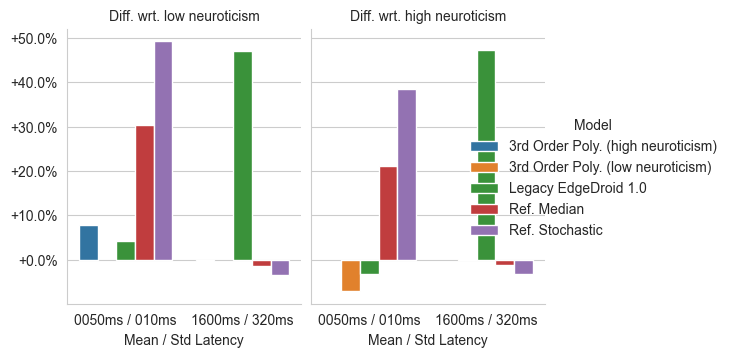

,lat_var,model,diff,value
0,0050ms / 010ms,3rd Order Poly. (high neuroticism),Diff. wrt. low neuroticism,0.076993
1,0050ms / 010ms,3rd Order Poly. (low neuroticism),Diff. wrt. high neuroticism,-0.071489
2,0050ms / 010ms,Legacy EdgeDroid 1.0,Diff. wrt. high neuroticism,-0.032153
3,0050ms / 010ms,Legacy EdgeDroid 1.0,Diff. wrt. low neuroticism,0.042364
4,0050ms / 010ms,Ref. Median,Diff. wrt. high neuroticism,0.211569
5,0050ms / 010ms,Ref. Median,Diff. wrt. low neuroticism,0.304851
6,0050ms / 010ms,Ref. Stochastic,Diff. wrt. high neuroticism,0.386146
7,0050ms / 010ms,Ref. Stochastic,Diff. wrt. low neuroticism,0.492870
8,1600ms / 320ms,3rd Order Poly. (high neuroticism),Diff. wrt. low neuroticism,-0.002223
9,1600ms / 320ms,3rd Order Poly. (low neuroticism),Diff. wrt. high neuroticism,0.002228


In [8]:
plot_relevant_diffs = (
    relevant_diffs
    .droplevel(level=1)
    .rename(columns={"task_duration_diff_high_neuro": "Diff. wrt. high neuroticism", "task_duration_diff_low_neuro": "Diff. wrt. low neuroticism"})
    .stack()
    .reset_index()
    .rename(columns={0: "value", "level_2": "diff"})
)
plot_relevant_diffs.lat_var = plot_relevant_diffs.lat_var.cat.remove_unused_categories()

fg = sns.catplot(kind="bar", data=plot_relevant_diffs, x="lat_var", hue="model", col="diff", y="value", height=4)
for ax in fg.axes.flat:
    ax.yaxis.set_major_formatter("{x:+0.1%}")

fg.set_axis_labels("Mean / Std Latency", "")
fg.set_titles(col_template="{col_name}")
fg.legend.set_title(title="Model")
fg.figure.set_size_inches((DOUBLE_COL_FIGW, DOUBLE_COL_FIGW/2))
plt.show()
# tpl.save("./frame_corr_diff.tex")

plot_relevant_diffs

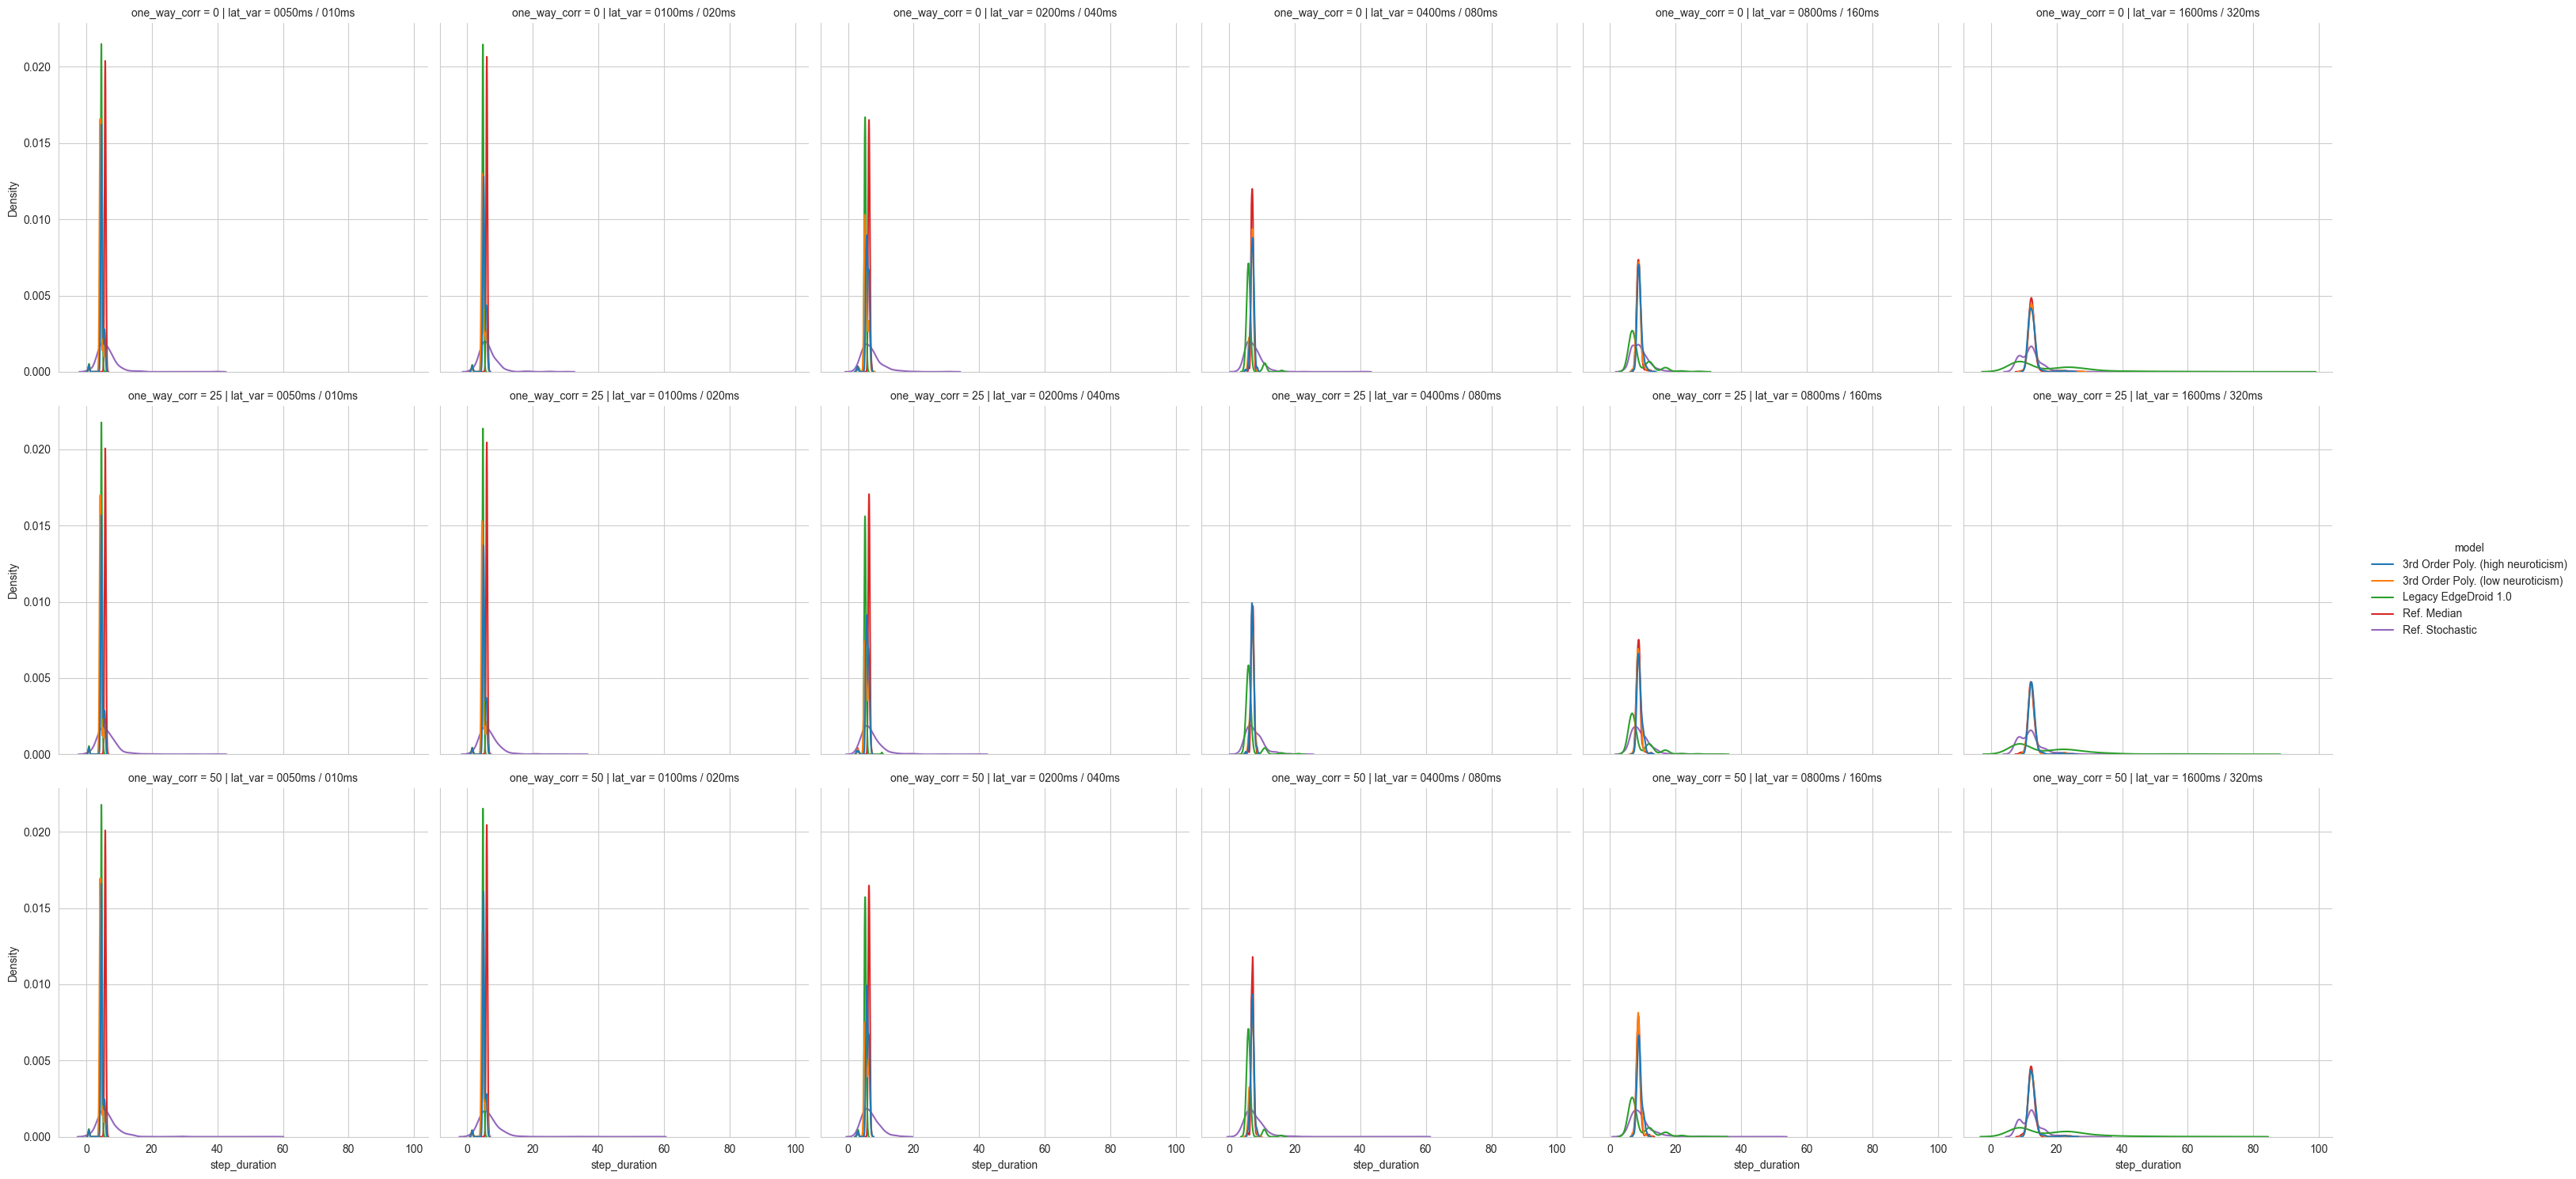

In [9]:
fg = sns.displot(data=data, kind="kde", x="step_duration", hue="model", col="lat_var", row="one_way_corr", legend=True)
# fg.set(xscale="log")
plt.show()

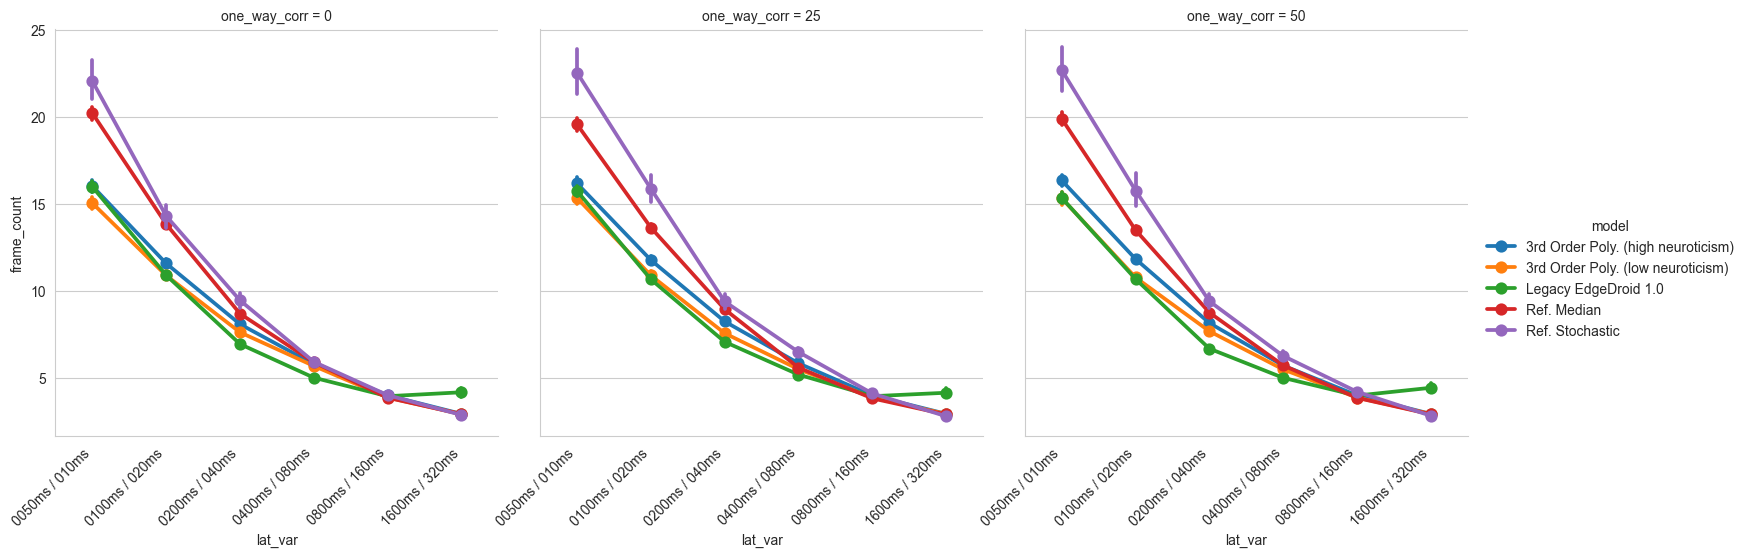

In [10]:
fg = sns.catplot(kind="point", data=data, x="lat_var", y="frame_count", col="one_way_corr", hue="model")
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [11]:
data["rep"].max()

10

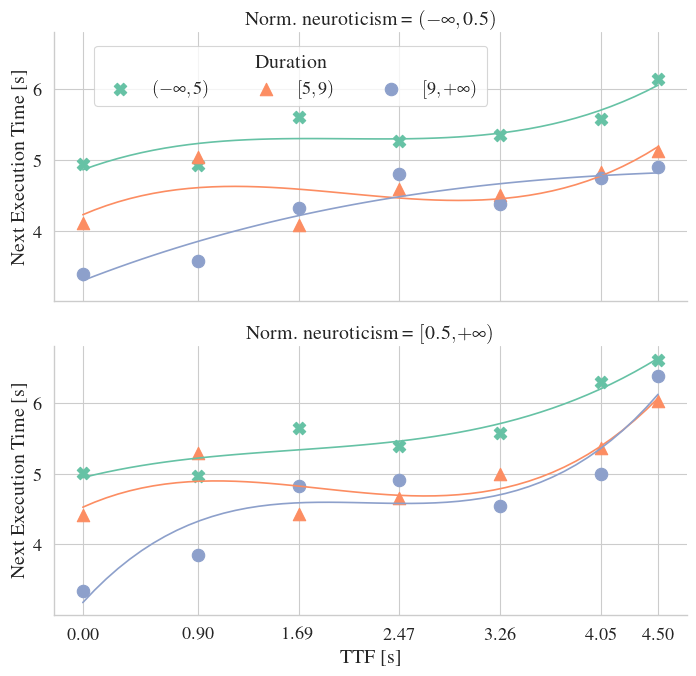

In [30]:
from edgedroid.models import MultiCurveFittingExecutionTimeModel
from edgedroid.models.timings.curve import CubeFit, outliers_to_nan_then_mean
sns.set_theme()
sns.set_theme(context="paper", font_scale=1.5, style="whitegrid", palette="Set2")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times",
    "font.sans-serif": "Computer Modern",
})

curve_data = MultiCurveFittingExecutionTimeModel.get_data()
curve_agg = (
    curve_data.groupby(["prev_duration", "prev_ttf", "neuro"], observed=True)[
        "exec_time"
    ]
    .aggregate(outliers_to_nan_then_mean)
    .reset_index()
)

def neuro_range_to_latex(x):
    if x.left == -np.inf:
        return r"$ (-\infty, 0.5) $"
    return r"$ [0.5, +\infty) $"

def duration_range_to_latex(x):
    if x.left == -np.inf:
        return r"$ (-\infty, 5) $"
    elif x.left == 5:
        return r"$ [5, 9) $"
    return r"$ [9, +\infty) $"

curve_agg["neuro_plot"] = curve_agg["neuro"].apply(neuro_range_to_latex)
curve_agg["prev_duration_plot"] = curve_agg["prev_duration"].apply(duration_range_to_latex)

fg = sns.FacetGrid(data=curve_agg, row="neuro_plot", hue="prev_duration_plot", legend_out=False)

label_marker = {
    r"$ (-\infty, 5) $": "X",
    r"$ [5, 9) $": "^",
    r"$ [9, +\infty) $": "o",
}

def plot_func(prev_ttf, exec_time, color, label):
    fit = CubeFit(prev_ttf, exec_time)
    min_ttf = prev_ttf.min()
    max_ttf = prev_ttf.max()

    x = np.linspace(min_ttf, max_ttf, 50)
    y = fit.y(x)

    ax = plt.gca()
    ax.plot(x, y, color=color)
    ax.scatter(prev_ttf, exec_time, color=color, label=label, marker=label_marker[label], s=80)
    ax.set_xticks(prev_ttf)
    ax.xaxis.set_major_formatter("{x:0.2f}")
    # ax.set_xticks(prev_ttf, ax.get_xticklabels(), rotation=45, ha='right')


fg.map(plot_func, "prev_ttf", "exec_time")
fg.set_titles(row_template="Norm. neuroticism = {row_name}")
fg.set_axis_labels("TTF [s]", "Next Execution Time [s]")
fg.add_legend()
sns.move_legend(fg, "upper center", bbox_to_anchor=(.42, .93), ncols=3, title="Duration")
fg.fig.set_size_inches((2*3.6, 2*3.5))
fg.tight_layout()
plt.savefig("../Sept2024_experiments/plots/curve_fit_example.pdf", dpi=500, bbox_extra_artists=[fg.legend], bbox_inches='tight') 
plt.show()

In [13]:
m = MultiCurveFittingExecutionTimeModel(neuroticism=1.0)
for dur, fn in m._exec_time_funcs.items():
    print(fn.name)

a * x^3 + b * x^2 + c * x + d
a * x^3 + b * x^2 + c * x + d
a * x^3 + b * x^2 + c * x + d
